# Data Science TP6
Tientso Ning

In [2]:
import numpy as np
from scipy.stats import norm
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

<b>Values taken from previous TP (with some corrections made):</b>

H(U) = 0.625log(0.625) + 0.375log(0.375) = 0.9544

H(U|V) = 0.9512

H(W) = 1.0

H(W|U) = 0.4512

H(U|V,W) = 0.3443

I(U;V) = H(U) - H(U|V) = 0.9544 - 0.9512 = 0.0032

I(U;W) = H(W) - H(W|U) = 1.0 - 0.4512 = 0.5488

I(U;V,W) = H(U) - H(U|V,W) = 0.9544 - 0.3443 = 0.6101

# Binary Hypothesis Testing

### 1. General Idea
a. H<sub>0</sub> : x[t] = w[t], where t is some time-step.
   H<sub>1</sub> : x[t] + A = w[t] + A, where A is our signal

b. According to the approximation of the Q function (seen below), our minimum required sample is 39.

In [9]:
#Estimation of the Q-function
gamma = 0.5
for N in range(30, 40): #try from 30 to 40 to get a feel
    L = math.sqrt(N)
    print(norm.sf(gamma*L))

L = math.sqrt(39)
print("Best: ",norm.sf(gamma*L)) #confirmed

0.00308494966027208
0.0026856270607900595
0.0023388674905236288
0.0020376000457602
0.0017757324038530362
0.0015480102749795086
0.0013498980316300933
0.0011774771258472425
0.0010273594880659044
0.0008966135759250296
Best:  0.0008966135759250296


### 2. Communications System

In [16]:
#try to estimate original x
def detection(channel):
    result = []
    for i in range(0, len(channel), 39):
        estimate = sum(channel[i:i+40])/39
        if estimate >= 0.5:
            result.append(1)
        else:
            result.append(0)
    return result

In [17]:
bit_sequence = np.random.randint(2, size=(10000,))
x = np.repeat(bit_sequence, N) #repeats each bit N times
z = np.random.randn(390000) #gaussian noise
y = np.add(x,z) #y output
x_hat = detection(y) #x_hat estimation

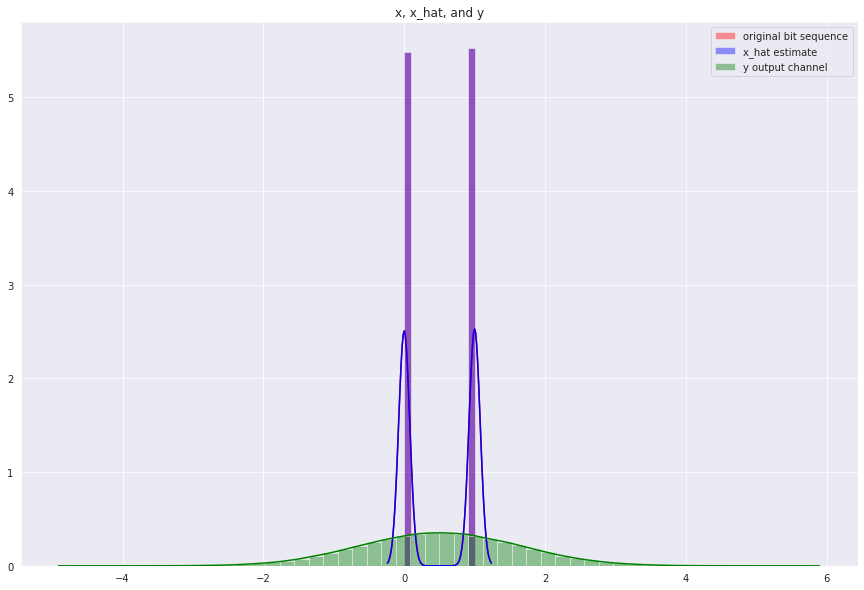

In [85]:
f = plt.figure(figsize=(15,10))
with sb.axes_style("darkgrid"):
    ax = sb.distplot(bit_sequence, color = 'red', label="original bit sequence") #original bit sequence
    bx = sb.distplot(x_hat, color='blue', label="x_hat estimate") #x_hat estimate
    cx = sb.distplot(y, color='green', label="y output channel") #y-output channel
    ax.set_title("x, x_hat, and y")
    ax.legend()

<b> Notice that the red and the blue bars overlap (generating a purple color), meaning that the x_hat estimate estimate matches the original bit sequence. The green noise distribution also centers around between 0 and 1, which is what we should be expecting adding noise to the bit sequence. </b>

In [19]:
#comparing probility of miss and false acceptance
def compare(original, estimate):
    Pm = 0.0
    Pfa = 0.0
    
    for i in range(0, len(original)):
        if original[i] == estimate[i]:
            pass
        else:
            if original[i] == 0 and estimate[i] == 1:
                Pfa += 1
            elif original[i] == 1 and estimate[i] == 0:
                Pm += 1
                
    Pm = Pm/len(original)
    Pfa = Pfa/len(original)
    Pe = Pm+Pfa
    return Pm, Pfa, Pe 

In [20]:
prob_miss, prob_falseaccept, prob_e = compare(bit_sequence, x_hat)
print(prob_miss)
print(prob_falseaccept)
print(prob_e)

0.0005
0.0005
0.001


<b> Compared to the analytical values, these values for Probability of Miss, and False Acceptance are lower than we derived (0.0005 compared to 0.001), and the Probability of Error is miniscule, as desired. </b>

### 3. Neyman-Pearson Approach
a. The Hypothesis Testing Setup:
* H<sub>0</sub> : x[t] = w[t], where t is some time-step
* H<sub>1</sub> : x[t] = N + w[t], where N is the Gaussian signal
* Detection Rule according to Neyman-Pearson approach is to set Pm or Pfa to be a set value, and derive the other based on the first selection. i.e: set Pfa <= gamma, where gamma is some value like 10<sup>-6</sup>

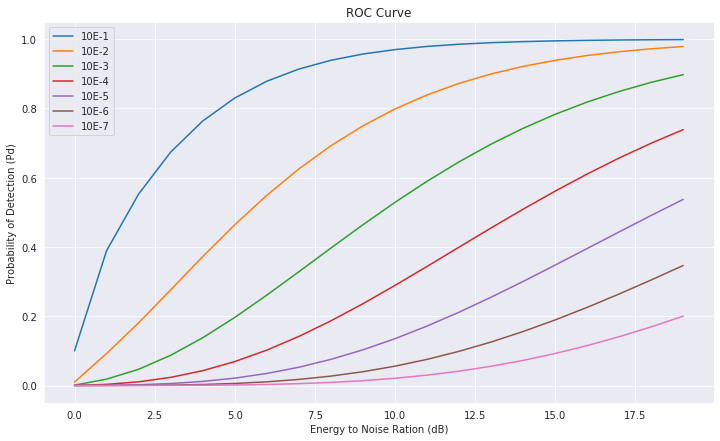

In [75]:
#plot the ROC-curve
sigma = 1
mu = 1
g_signal = sigma*np.random.randn(10000)+mu #gaussian signal length 10000, centered around 1
noise_ = np.random.randn(10000) #standard gaussian white noise
channel = g_signal+noise_ #channel

Pfa = [10**(-1*x) for x in range(1,8)] #from range 10E-1 to 10E-7


Pd = []
for i in range(0,len(Pfa)):
    Pd_x = []
    for j in range(20):
        val = norm.sf(((norm.isf(Pfa[i]))-math.sqrt(j)))
        Pd_x.append(val)
    Pd.append(Pd_x)
Pd = np.asarray(Pd)
Pd = np.transpose(Pd)
data = pd.DataFrame(Pd, columns=['10E-1','10E-2','10E-3','10E-4','10E-5','10E-6','10E-7'])

f = plt.figure(figsize=(12,7))
with sb.axes_style("darkgrid"):
    ax = sb.lineplot(data=data, dashes=False)
    ax.set_title("ROC Curve")
    ax.set(xlabel="Energy to Noise Ration (dB)", ylabel="Probability of Detection (Pd)")

<b>Detection accuracy increases as the ratio between the length of the signal and the variance of the noise increases.</b>

# Multiple Hypothesis Testing

In [73]:
M = 200
n = 1000
X = np.random.randn(M,n) #200x1000 matrix
noise_ = 100*np.random.rand(M,n) #standard deviation of 100
Y = X+noise_

In [103]:
def find_closest(x,y):
    #find the appropriate x
    results = []
    for i in range(0, Y.shape[0]):
        results.append(np.argmin([np.linalg.norm(y[i]-x[j]) for j in range(0, X.shape[0])]))
    return results

In [104]:
matches = find_closest(X,Y)
print(matches)

[166, 142, 142, 47, 166, 140, 197, 136, 28, 136, 120, 166, 28, 136, 140, 151, 142, 140, 2, 28, 142, 142, 142, 140, 142, 28, 140, 28, 142, 28, 64, 63, 9, 28, 166, 142, 140, 47, 140, 142, 140, 140, 140, 28, 28, 28, 9, 142, 140, 198, 140, 166, 142, 151, 198, 166, 93, 142, 163, 140, 140, 136, 167, 9, 64, 28, 140, 28, 140, 140, 142, 197, 142, 28, 166, 166, 166, 142, 140, 140, 197, 28, 28, 28, 28, 140, 142, 140, 28, 197, 2, 2, 142, 140, 142, 140, 166, 28, 28, 142, 136, 140, 197, 142, 47, 167, 140, 140, 197, 93, 9, 140, 140, 140, 28, 93, 28, 47, 140, 142, 28, 2, 28, 140, 140, 142, 2, 142, 142, 28, 166, 28, 140, 142, 93, 47, 140, 140, 166, 142, 166, 166, 63, 140, 28, 28, 140, 163, 28, 142, 140, 151, 142, 140, 140, 140, 136, 142, 28, 166, 2, 64, 28, 140, 140, 142, 166, 140, 2, 141, 28, 28, 136, 140, 28, 166, 28, 2, 28, 140, 166, 28, 28, 142, 166, 140, 140, 140, 64, 28, 197, 140, 140, 140, 28, 140, 28, 28, 47, 197]


In [97]:
#calculate the probability of error